In [ ]:
!pip install pandas-plink limix-lmm

In [2]:
import numpy as np
import pdb
from pandas_plink import read_plink
from limix_lmm import LMM
import pylab as plt
import os
import pandas as pd

In [4]:
# --- Compatibility patch for SciPy deprecations (Colab / Python 3.12) ---
# Some older packages such as `limix` still reference deprecated SciPy functions
# like `scipy.log`, `scipy.exp`, and `scipy.sqrt`. These were removed starting from
# SciPy 1.12 (2024) and are no longer available in recent Python environments.
#
# On Google Colab, the default Python version is currently 3.12, which only supports
# SciPy >= 1.12. Older versions of SciPy (<= 1.10.1), which still provided these
# functions, cannot be installed because they require Python < 3.12.
#
# Therefore, we manually alias these missing functions to their NumPy equivalents.
# This "monkey patch" allows legacy code (e.g., `limix`) to run under the current
# Colab setup without downgrading Python or SciPy.
# -----------------------------------------------------------------------------

import scipy
import scipy.stats as st

if not hasattr(scipy, 'dot'):
    scipy.dot = np.dot
if not hasattr(scipy, 'einsum'):
    scipy.einsum = np.einsum
if not hasattr(scipy, 'log'):
    scipy.log = np.log
if not hasattr(scipy, 'sign'):
    scipy.sign = np.sign
if not hasattr(scipy, 'sqrt'):
    scipy.sqrt = np.sqrt

## Loading Genetic Data from 1000 Genomes

In this code segment, we are dealing with genetic data derived from the 1000 Genomes Project. Let's break down some context and terminology:

- **1000 Genomes Dataset**:
  - A comprehensive public resource that provides data on the genetic makeup of 2504 individuals from 26 different populations around the world.
  - It's an effort to sequence the genomes of a large number of people to provide a comprehensive resource on human genetic variation.
  - In our current scenario, we are utilizing just a subset of this extensive dataset.

- **PLINK Files**:
  - PLINK is a free, open-source whole genome association analysis toolset, which operates on a range of binary dataset types.
  - The dataset is typically represented in three primary files:
    - `.bim` (Binary Marker File): Contains information about the genetic markers (like SNPs).
    - `.fam` (Family File): Contains information about the individuals (like their IDs, phenotype).
    - `.bed` (Binary PED File): Contains the genotype data in a binary format.
  - Together, these files give a comprehensive picture of both the individuals in the dataset and their genetic variations.

- **Loading Data in Python**:
  - The `read_plink` function from the `pandas_plink` library in Python can be used to load PLINK binary datasets.
  - Once loaded, we can manipulate and analyze this data using standard Python tools and libraries.

The code `bim, fam, G = read_plink(bfile)` essentially reads the genetic data from the specified PLINK binary files and stores the marker information in `bim`, the family/individual information in `fam`, and the genotype matrix in `G`.


In [6]:
!wget -O ALL.chr22_GRCh38.genotypes.20170504.zip "https://www.dropbox.com/s/86fdj3i7ir3vap7/ALL.chr22_GRCh38.genotypes.20170504.zip?dl=1"
#!unzip -o -q ALL.chr22_GRCh38.genotypes.20170504.zip && rm ALL.chr22_GRCh38.genotypes.20170504.zip

--2025-11-18 12:44:42--  https://www.dropbox.com/s/86fdj3i7ir3vap7/ALL.chr22_GRCh38.genotypes.20170504.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/2j079oew31gwd2hzajlil/ALL.chr22_GRCh38.genotypes.20170504.zip?rlkey=7307x4sjq9lkvhwu3aivh5uut&dl=1 [following]
--2025-11-18 12:44:42--  https://www.dropbox.com/scl/fi/2j079oew31gwd2hzajlil/ALL.chr22_GRCh38.genotypes.20170504.zip?rlkey=7307x4sjq9lkvhwu3aivh5uut&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5024b1801f9d5f9cffb60b87b5.dl.dropboxusercontent.com/cd/0/inline/C1ZU9yBUgzpu8DhLDHMspM7EK30I1HF2Hhzg-kQ6urGyKQ3E2eLcEZXnO_vad39-Jv9RQ2WblWsXiepMFW9tMRsOE5eklaBTW-VEneHmzhP9ej3Ni9yEaUo5xS969zFHLY4/file?dl=1# [following]
--2025-11-18 12:44:4

In [7]:
!unzip -o -q ALL.chr22_GRCh38.genotypes.20170504.zip && rm ALL.chr22_GRCh38.genotypes.20170504.zip

In [8]:
# load genetic data
bfile = 'ALL.chr22_GRCh38.genotypes.20170504'
bim, fam, G = read_plink(bfile)


Mapping files: 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]
/usr/local/lib/python3.12/dist-packages/pandera/_pandas_deprecated.py:149: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [9]:
def extract_region(bim, G, chrom, start, end):
    I1 = bim['chrom']==str(chrom)
    I2 = bim['pos'] > start
    I3 = bim['pos'] < end
    Ikeep = I1 * I2 * I3
    bim = bim.loc[Ikeep].copy()
    G = G[bim['i'].values]
    bim['i'] = np.arange(len(bim))
    return bim, G

In [10]:
def subset_individuals(fam, G, keep_idxs):
    fam = fam.iloc[keep_idxs]
    G = G[:, keep_idxs]
    return bim, G

In [11]:
# subset to 1000 individuals
N = 1000
np.random.seed(0)
idxs = np.sort(np.random.permutation(fam.shape[0])[:N])
fams, Gs = subset_individuals(fam, G, idxs)

In [12]:
# extract region
chrom = 22
start = 30797531
size = 100000
bimr, Gr = extract_region(bim, Gs, chrom, start, start + size)

In [13]:
# load genotype matrix
X_real = Gr.compute().T

## Function: `simulate_pheno`

### Description:
The `simulate_pheno` function is designed to simulate phenotypic values based on a given genotype matrix, a set of causal variant indices, and the variance explained by these causal variants. The phenotype is simulated as the sum of the genetic component and a noise component.

### Parameters:

- **`X`**: Genotype matrix. Rows represent individuals, and columns represent genetic variants.
  
- **`idx_caus`**: A list of indices specifying which columns (genetic variants) in the `X` matrix are causal for the trait.
  
- **`var_expl`**: A list of variances explained by each causal variant. This indicates how much of the phenotypic variance each causal variant explains. The sum of `var_expl` values should be less than 1.

- **`direction`** (optional): A list of directions for the effect of each causal variant. If not provided, it is randomly assigned as either positive or negative for each causal variant.

### Returns:

- **`y`**: The simulated phenotypic values. It's the sum of the genetic component and a noise component.
  
- **`beta_real`**: The real effect sizes of all variants in `X` after standardization.

### Notes:
The genetic component of the phenotype is determined by the genotypes of the causal variants, their effect sizes, and their directions. The noise component is normally distributed random noise. The phenotypic values (`y`) are then standardized to have a mean of 0 and a standard deviation of 1. The real effect sizes (`beta_real`) are adjusted accordingly after standardizing `y`.


In [14]:
def simulate_pheno(X, idx_caus, var_expl, direction=None):
    # Ensure that the number of causal variant indices matches the number of variances explained.
    assert len(idx_caus) == len(var_expl)

    # If no direction is provided, randomly assign a positive or negative direction for each causal variant.
    if direction is None:
        direction = 2. * (np.random.rand(len(idx_caus)) > 0.5) - 1.
    # Ensure that the number of directions matches the number of causal variant indices.
    assert len(idx_caus) == len(direction)

    # Compute the remaining variance after accounting for the variance explained by the causal variants.
    ve = 1 - var_expl.sum()
    # Ensure that the total variance explained by causal variants is less than 1.
    assert ve > 0, 'sum(var_expl) should be < 1'

    # Compute the effect sizes for the causal variants based on the variance they explain and their direction.
    beta = np.sqrt(var_expl) * direction

    # Extract the columns of X corresponding to the causal variants and standardize them.
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)

    # Compute the genetic component of the phenotype.
    yg = Xc.dot(beta)[:, None]
    # Compute the noise component of the phenotype.
    yn = np.sqrt(ve) * np.random.randn(X.shape[0], 1)

    # Sum the genetic and noise components to get the simulated phenotype.
    y = yg + yn

    # Initialize the real effect sizes for all variants in X as zeros.
    beta_real = np.zeros(X.shape[1])
    # Update the real effect sizes for the causal variants.
    beta_real[idx_caus] = beta

    # Standardize the phenotypic values to have mean 0 and standard deviation 1.
    ystd = y.std()
    y = (y - y.mean()) / ystd
    # Adjust the real effect sizes accordingly after standardizing y.
    beta_real = beta_real / ystd

    return y, beta_real

In [15]:
def qq_plot(ax, p_values):
    """
    Create a QQ plot given a list of p-values.

    Parameters:
    - p_values: list of p-values
    - figsize: size of the plot
    - title: title for the plot
    """

    # Sort p-values
    observed = -np.log10(np.sort(p_values))
    expected = -np.log10(np.arange(1, len(p_values) + 1) / (len(p_values) + 2))

    # Create the QQ plot
    plt.scatter(expected, observed, marker='.')
    plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--')
    plt.xlabel('Expected -log10(P-value)')
    plt.ylabel('Observed -log10(P-value)')

## Simulate pheno, perform local GWAS and compare groundtruth with GWAS results

### Code Explanation

- **Data Source Decision**:
  - There's a variable called `simulated_data` that decides if the genetic data (`X`) is simulated or taken from a real dataset (`X_real`).
  - If `simulated_data` is set to `True`, the genotype matrix `X` is generated using a binomial distribution based on the mean allele frequency of the real dataset (`X_real`).
  - If set to `False`, the code uses the `X_real` as the genotype matrix.

- **Phenotype Simulation**:
  - The phenotype `y` is generated using the function `simulate_pheno` based on the genotype matrix, indices of causal variants (`idx_caus`), and variance explained by these causal variants (`var_expl`).

- **Genetic Association Testing**:
  - A linear mixed model (`LMM`) is used to test the association between genotypes and the simulated phenotype.
  - The results include p-values (`pv`) indicating the significance of the association, the effect sizes (`beta`), and the standard error of these effect sizes (`beta_ste`).

- **Visualization**:
  - The real effect sizes (`beta_real`) and the association results are visualized using two subplots.
  - Additionally, a QQ plot is generated to compare the distribution of the observed p-values to the expected uniform distribution.
  
---
  
### Activity

Now that you understand the code's flow and functionality, it's your turn to experiment with it and observe the effects of different parameters. Here are some questions to guide your exploration:

1. **Linkage Disequilibrium (LD) Effects**:
   - What happens when you switch between simulated and real genetic data? How do the GWAS results differ, especially in terms of the distribution of p-values?
   
2. **Number of Causal Variants**:
   - Currently, only 1 causal variant (`n_causal = 1`) is selected at random. What happens if you increase this number? Try 2, 5, or even 10. How do the results change, especially in terms of power and false discovery rate?

3. **Variance Explained**:
   - The current variance explained by the causal variant is set to 0.05 (`var_expl = np.array([0.05])`). How do the results vary if you increase or decrease this value?

4. **Combining Factors**:
   - How do the results change when you vary both the number of causal variants and the variance they explain simultaneously?

---

Experiment with these questions, modify the code, and see how the visualizations and outcomes change. This exercise will give you a deeper understanding of how different factors impact genetic association results.


In [16]:
# Variable to decide if the data is simulated or real
simulated_data = True

# If the data is simulated
if simulated_data:
    X = np.random.binomial(2, 0.5 * X_real.mean(0), (N, X_real.shape[1]))
else:
    X_real = X

In [17]:
# Generate phenotype
n_causal = 1
idx_caus = np.random.choice(X.shape[1], size=n_causal)
var_expl = np.array([0.05])
y, beta_real = simulate_pheno(X, idx_caus, var_expl)

In [18]:
# Perform genetic association testing
F = np.ones_like(y)
lmm = LMM(y, F)
lmm.process(X)
pv = lmm.getPv()
beta = lmm.getBetaSNP()
beta_ste = lmm.getBetaSNPste()

In [26]:
# TODO: Create and show QQ plot


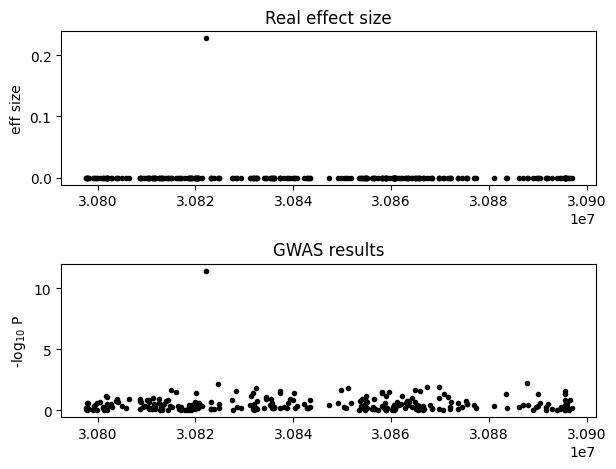

In [20]:
# Plot ground truth and results
x = bimr['pos'].values
plt.subplot(211)
plt.title('Real effect size')
plt.plot(x, beta_real, '.k')
plt.ylabel('eff size')
plt.subplot(212)
plt.title('GWAS results')
plt.plot(x, -np.log10(pv), '.k')
plt.ylabel('-log$_{10}$ P')
plt.tight_layout()
plt.show()

#### Open Question
Play with the parameters adn describe what you see in the clearest adn shortest way possible

## Assignment for Next Session: GCTA Analysis

In this assignment, you will work with **GCTA** (Genome-wide Complex Trait Analysis). GCTA is one of the most frequently used software tools for genetic association studies, primarily due to its speed and robustness. It has been widely adopted by the scientific community for performing large-scale genetic analyses.

[GCTA's official website](https://yanglab.westlake.edu.cn/software/gcta/#Overview) contains documentation and download instructions. For our session, please make sure to install and familiarize yourself with it.

### The Task:

1. **Phenotype Simulation**: Using the provided code, simulate a phenotype based on a genotype matrix.
2. **File Exportation**: Export the phenotype and covariates in the required format for GCTA.
3. **Run GCTA**: Execute the GCTA command to perform a genome-wide association analysis on the simulated data.
4. **Results Importation**: Once GCTA has processed the data, import the results back into Python using pandas.

Here's the provided code block to help you get started:

In [ ]:
!wget https://cnsgenomics.com/software/gcta/bin/gcta_1.94.1Linux.zip
!unzip gcta_1.94.1Linux.zip
!chmod +x gcta64

In [ ]:
# Assuming X is your genotype matrix, which should be defined or imported beforehand.
n_causal = 1
idx_caus = np.random.choice(X.shape[1], size=n_causal)
var_expl = np.array([0.05])
y, _ = simulate_pheno(X, idx_caus, var_expl)

In [22]:
# Step 2: Export phenotype in the right format for GCTA
pheno_file = "pheno.txt"
with open(pheno_file, "w") as f:
    for i, value in enumerate(y):
        f.write(f"{i+1}\t{i+1}\t{value[0]}\n")

# Define arbitrary random covariates and save them
dcovars_file = "covars.txt"
num_samples, num_features = X.shape
covariates = np.random.rand(num_samples, 5)  # Assuming 5 random covariates
np.savetxt(dcovars_file, covariates, delimiter="\t")

In [23]:
# Step 3: Run GCTA

# TODO: Replace these with your own settings
gcta_path = "./gcta64"
mbfile = "/path/to/mbfile"
maf_value = 0.05
output_file = "gcta_results"

command = (
    f"{gcta_path} "
    f"--mbfile {mbfile} "
    f"--maf {maf_value} "
    f"--pheno {pheno_file} "
    f"--mpheno 1 "
    f"--covar {dcovars_file} "
    f"--out {output_file} "
    f"--fastGWA-lr "
    f"--nofilter "
    f"--seed 0"
)
os.system(command)

32512

In [25]:
# Step 4: Import the results with pandas

results = pd.read_csv(f"{output_file}.assoc.txt", sep="\t")
print(results)

#### Clump the results using PLINK

#### Question
* Replicate state-of-the-art GWAS on a single chromosome using plink and clumping
* Get the best single chromosome manhattan plot you can (show clumps, optimize for beauty, etc)